# Import libraries

In [1]:
import math
import torch
import numpy as np
import tensorly as tsl
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from scipy.sparse import csr_matrix, linalg
from scipy.sparse.linalg import spsolve
from tensorly.decomposition import tensor_ring
%matplotlib inline

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# 1 - NTRC Algorithm

This session is the implementation for **Algorithm 1 - NTRC** from the orginal paper [1]

**My purpose** is to implement exactly the same as the Algorithm (as much as I can & understand), with some deviations below:

* **Stop condition** for the loop of algorithms:
    * In paper:     $convergence(T_t, T_{t+1}) <= tol (10^{-6})$
    * In this code: $tol (10^{-6}) <= RE(T_t, T^*) <= 100$
    * Reason: from my observation, the $convergence$ in some first iterations is smaller than $tol$, but the image still hasn't reconstructed yet. I think it would be better with stop condition is the $min(RE)$, but after a lowest point, the $RE$ is rapidly increase -> I need to define upper boundary for it

In [3]:
def NTRC_algorithm(y, Xn, T, Tk, K, lambda_, alpha_k, tol=1e-6, max_iter=500, isPlot=False):
    # Initialization
    mu = 1e-4
    nu = 1.1
    mu_max = 1e10    
    threshold_re = 100
    D = int(np.prod(T.size()))    
    Mk = []
    Qk = []
    for k in range(K):
        Mk.append(torch.zeros_like(Tk[k]))
        Qk.append(torch.zeros_like(Tk[k]))
    t = 1
    # addition parameter for output tracking purpose
    T_prev = T.clone()
    convergence = []    #list contains the convergence(t)
    relative_error = [] #list contains the RE(t)
    PSNR = []           #list contains the PSNR(t)
    T_plt=[]            #list use to store the image output during the reconstruct process (when isPlot = True)
    min_re = float('inf')

    # Main loop
    while True:
        # Update Mk
        for k in range(K):
            A = Tk[k] - (1/mu)*Qk[k]
            U, S, V = torch.svd(A)
            tau = lambda_*alpha_k/mu
            Vt = V.t()
            S_threshold = torch.diag(torch.max(S-tau, torch.zeros_like(S)))
            Mk[k] = U @ S_threshold @ Vt

        # Update Tk
        T = update_T(y, Xn, T, K, mu, Qk, Mk)

        # Update Qk
        for k in range(K):
            Qk[k] = Qk[k] + mu * (Mk[k] - Tk[k])

        # Update mu
        mu = min(mu_max, nu * mu)

        # Check convergence, store the values 
        t_conv = (torch.norm(T - T_prev, 'fro')**2) / (torch.norm(T_prev, 'fro')**2)
        t_re   = (torch.norm(T - y, 'fro')**2) / (torch.norm(y, 'fro')**2)
        t_psnr = 10 * torch.log10(D* (torch.max(torch.abs(T))**2) / (torch.norm(T - y, p='fro') ** 2))
        convergence.append(t_conv)
        relative_error.append(t_re)
        PSNR.append(t_psnr)
        if isPlot:
            if t%5==0:
                print(f'{t:<7} conv:{t_conv:<25} RE:{t_re:<20} PSNR:{t_psnr}')
            if t%25==0:
                T_plt.append(T.clone())

        # Store the min RE tensor for output visualization
        if t_re <= min_re:
            Tmin = T.clone()
            min_re = t_re
        
        # Check for the stop condition 1e-6 <= RE <= 100 
        if t_re <= tol:
            break
        elif t_re >= threshold_re:
            break

        # Update iteration
        t += 1
        if t > max_iter:
            break

        # Keep track of previous T
        T_prev = T.clone()

    return Tmin, T_plt, convergence, relative_error, PSNR

def update_T(y, Xn, T, K, mu, Qk, Mk):
    D = int(np.prod(T.size()))
    #Vectorizing tensors 
    vecX = torch.flatten(Xn)
    vecQM = torch.flatten(Qk[0] + Mk[0])
    for i in range(1,K):
        vecQM += torch.flatten(Qk[i] + Mk[i])
        
    # Create sparse matrix representation of the large I(DxD) matrix
    bigID = torch.ones(D) * mu * K + vecX.t()@vecX # Diagonal elements
    row = torch.arange(D)
    col = torch.arange(D)
    sparse_matrix = csr_matrix((bigID.numpy(), (row.numpy(), col.numpy())), shape=(D, D))

    # Solves the sparse linear system without explicitly computing the inverse of the matrix.
    ft_plus1 = torch.tensor(spsolve(sparse_matrix, (mu*vecQM - vecX@torch.flatten(y))))

    """Orginal code that cannot be used, because inverse of I(DxD) is a huge matrix & cannot compute directly"""
    # ft_plus1 = torch.pinverse((vecX.t() @ vecX) + mu*K*torch.eye(D)) @ (mu*vecQM - vecX@torch.flatten(y))

    T_plus1 = torch.sign(ft_plus1) * torch.min(torch.abs(ft_plus1), torch.tensor(mu))
    T_plus1 = T_plus1.view_as(T)

    return T_plus1

# 2 - Image Processing

## 2.1 - Import orginial image

In [4]:
# Load the image
image = Image.open("picture/trainImg.jpg")  # Replace "example_image.jpg" with the path to your image file
# Define transformations to resize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])
# Apply transformations
orginal_tensor3d = transform(image)

## 2.2 - Sampling & random noise image

This session is to process the orginal image to the missing entries & noisy image

There are 2 functions in this block:
* add_noise_uniformly: make noise for the image with standard deviation of Gaussian
* mask_tensor: randomly remove the entries of tensor with percentage (1-SR) - the higher the SR, the more entries are removed

I choose $SR=0.2$ (orginal paper uses $SR=0.4$)

In [5]:
SR = 0.2

In [6]:
def add_noise_uniformly(image_tensor, noise_std, sampling_ratio=0.4):
    """
    Add Gaussian noise to a percentage of pixels sampled uniformly at random from the image tensor.

    Args:
        image_tensor (torch.Tensor): Input image tensor.
        noise_std (float): Standard deviation of the Gaussian noise.
        sampling_ratio (float): Percentage of pixels to sample uniformly at random.

    Returns:
        torch.Tensor: Image tensor with noise added to selected pixels.
    """
    # Calculate the number of pixels to sample
    num_pixels = int(sampling_ratio * image_tensor.numel() / image_tensor.size(0))  # Number of pixels per channel

    # Create a mask to select pixels randomly
    mask = torch.zeros_like(image_tensor)
    mask.view(-1)[torch.randperm(image_tensor.numel())[:num_pixels]] = 1

    # Add Gaussian noise to the selected pixels
    noise = torch.randn_like(image_tensor) * noise_std
    noisy_tensor = image_tensor + mask * noise

    return noisy_tensor

import torch

def mask_tensor(tensor, mask_ratio=0.4):
    """
    Masks out a random portion of the values in the input tensor.

    Args:
        tensor (torch.Tensor): Input tensor.
        mask_ratio (float): Ratio of values to mask out.

    Returns:
        torch.Tensor: Tensor with masked values.
    """
    num_values = tensor.numel()  # Total number of values in the tensor
    num_values_to_mask = int(mask_ratio * num_values)  # Number of values to mask out

    # Create a mask tensor with zeros and ones (1 indicates values to keep)
    mask = torch.zeros_like(tensor)
    mask.view(-1)[torch.randperm(num_values)[:num_values_to_mask]] = 1

    # Apply the mask to the input tensor
    masked_tensor = tensor * mask

    return masked_tensor


# Calculate Frobenius norm of the image tensor
frobenius_norm = torch.norm(orginal_tensor3d, p='fro')
sqrt_D = math.sqrt(512*512*3)
s = ((0.25 * frobenius_norm) / sqrt_D).item()

noisy_tensor3d = add_noise_uniformly(orginal_tensor3d, noise_std=s, sampling_ratio=SR)
noisy_tensor3d = mask_tensor(noisy_tensor3d, mask_ratio=1-SR)
noisy_tensor5d = noisy_tensor3d.view(3, 16, 16, 32, 32)

# 3 - Tensor Ring Decomposition

This session creates initally tensor T = TensorRing $(\mathcal{G}_1, \mathcal{G}_2, ..., \mathcal{G}_5)$ & visualize the image after decomposed

Tensor Ring decomposition is supported by Tensorly library: https://tensorly.org/stable/modules/api.html#module-tensorly.decomposition

Size of tensor cores after decomposed:
G(1): torch.Size([1, 3, 2])
G(2): torch.Size([2, 16, 3])
G(3): torch.Size([3, 16, 4])
G(4): torch.Size([4, 32, 5])
G(5): torch.Size([5, 32, 1])
RE (noisy, decomposed ): 0.2921419143676758


Text(0.5, 1.0, 'Tensor Decomposed Image')

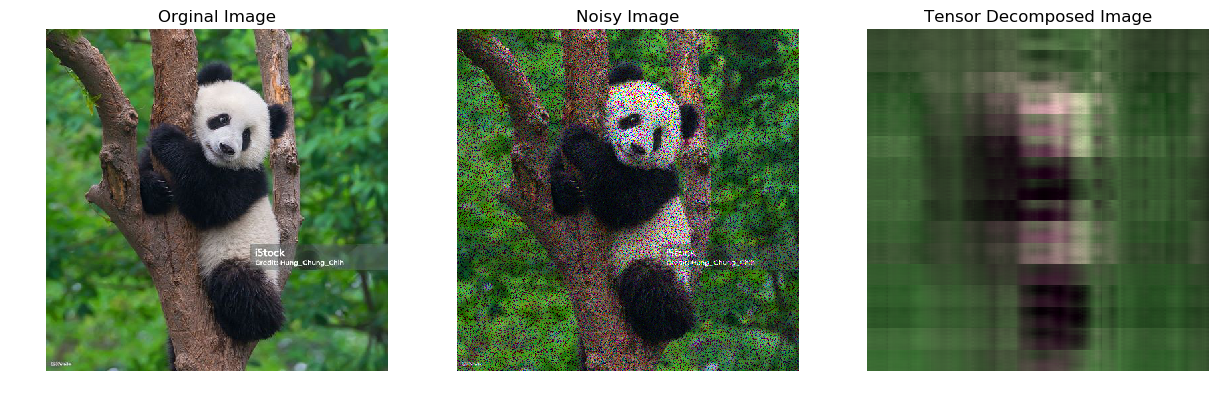

In [7]:
# Perform tensor ring decomposition
rank = [1, 2, 3, 4, 5, 1]  # Define the rank for each dimension
factors = tensor_ring(input_tensor=tsl.tensor(noisy_tensor5d), rank=rank)
T_approximate = tsl.tensor(factors)
print('Size of tensor cores after decomposed:')
for i,ts in enumerate(T_approximate):
    T_approximate[i] = torch.tensor(ts)
    print(f'G({i+1}): {T_approximate[i].shape}')

# Reconstruct the tensor from the decomposition
reconstructed_tensor5d = torch.einsum('abc, cde, efg, ghi, ijk -> bdfhj', T_approximate[0], T_approximate[1], T_approximate[2], T_approximate[3], T_approximate[4])

# Print the reconstruction error (Frobenius norm of the difference between the original and reconstructed tensor)
reconstructed_tensor3d = reconstructed_tensor5d.view(3, 512, 512)
reconstruction_error = torch.norm(noisy_tensor3d - reconstructed_tensor3d, p='fro')**2/torch.norm(noisy_tensor3d, 'fro')**2
print("RE (noisy, decomposed ):", reconstruction_error.item())

# Display the image
# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot the first image
axes[0].imshow(np.clip(orginal_tensor3d,0,1).permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('Orginal Image')
# Plot the second image
axes[1].imshow(np.clip(noisy_tensor3d,0,1).permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('Noisy Image')
# Plot the second image
axes[2].imshow(np.clip(reconstructed_tensor3d,0,1).permute(1, 2, 0))
axes[2].axis('off')
axes[2].set_title('Tensor Decomposed Image')

# 4 - Inputs Preparation

This session defines and creates nessary input for NTRC algorithm from session 1

In [8]:
K = 5
alpha_k = 1/K

## 4.1 - Create circular unfold tensors $T_{(k,s)}$

This session create 5 circular unfold tensors for Tensor Ring Completion, it means we flatten the 5D tensor into 2D matrix with the step is $\lceil K/2 \rceil$

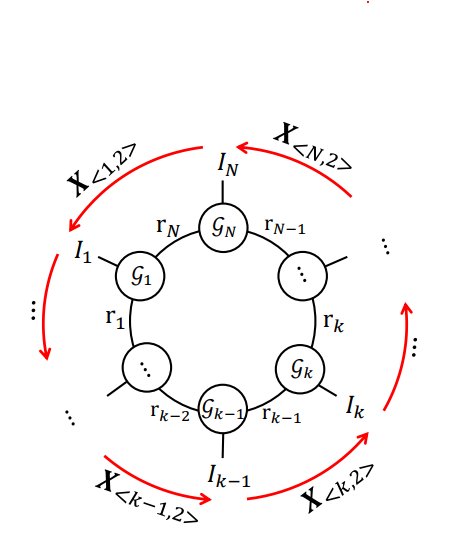 

Illustration of TR representation of a Nth-order tensor $X_{<k,2>}$ [2]

In [9]:
def circular_unfold(T, K_, s):
    Tks = []
    for k in range(K_):
        #Caculate the shape of permute
        l = k + s - 1 - K_*(k+s > K_)
        permuteShape = list(range(l+1, K_)) + list(range(l+1))

        # Calculate the shape of resize
        d1k=1
        d2k=1
        k_id = permuteShape.index(k)
        for i in range(k_id): #in range [l+1, k-1]
            d1k *= T.shape[permuteShape[i]]
        for j in range(k_id, K_): #in range [k, l]
            d2k *= T.shape[permuteShape[j]]

        unfold = T.permute(permuteShape).reshape(d1k, d2k)
        Tks.append(unfold)
        print(f'k:{k}, l:{l}, permuteShape: {permuteShape}, shape_of_unfold_matrix: {unfold.shape}')
    return Tks


circular_unfold_tensors = circular_unfold(T=noisy_tensor5d, K_=5, s=3)

k:0, l:2, permuteShape: [3, 4, 0, 1, 2], shape_of_unfold_matrix: torch.Size([1024, 768])
k:1, l:3, permuteShape: [4, 0, 1, 2, 3], shape_of_unfold_matrix: torch.Size([96, 8192])
k:2, l:4, permuteShape: [0, 1, 2, 3, 4], shape_of_unfold_matrix: torch.Size([48, 16384])
k:3, l:0, permuteShape: [1, 2, 3, 4, 0], shape_of_unfold_matrix: torch.Size([256, 3072])
k:4, l:1, permuteShape: [2, 3, 4, 0, 1], shape_of_unfold_matrix: torch.Size([512, 1536])


## 4.2 - Create uniform sampling tensor $\mathcal{X}_n$

This session create the sampling tensor $\mathcal{X}_n$, which is a random tensor bases drawn from uniform distribution.

In [10]:
def tensor_uniform_sampling(dims):
    # Create a grid of indices using torch.meshgrid
    grids = torch.meshgrid([torch.arange(dim) for dim in dims])
    
    # Reshape the grids to form a tensor of indices
    indices = torch.stack(grids, dim=-1)
    
    # Reshape dims to match the shape of indices
    dims_tensor = torch.tensor(dims, dtype=torch.float32).reshape(1, 1, -1)
    
    # Generate the tensor using broadcasting and tensor operations
    tensor = torch.prod(torch.sin(indices * (2 * math.pi / dims_tensor)), dim=-1)
    
    return tensor

uniform_sampled_tensors = tensor_uniform_sampling(noisy_tensor5d.shape)

c:\Users\User\.conda\envs\pytorchenv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# 5 - NTRC processing for a 512x512 image

## 5.1 - Experimentally select a for $\lambda$ input

Code block bellow formulate the $\lambda$ 

In [11]:
def calculate_lamda(a, T_star=noisy_tensor5d, Tk=circular_unfold_tensors, SR=SR):
    
    D = np.prod(T_star.size())
    sigma = 0.25 * T_star.norm() / (D ** 0.5)
    N = SR * D

    # Retreive shape of Tk
    Tk_shape = []
    for cut in Tk:
        Tk_shape.append((cut.shape[0], cut.shape[1]))
    #Find k* = argmin(d1k ^ d2k)
    k_star = np.argmin(np.min(np.array(Tk_shape), axis=1))
    #Find d~ = d1k + d2k
    d_approx = np.sum(Tk_shape[k_star])
    #Find d^ = d1k ^ d2k
    d_hat = min(Tk_shape[k_star])
    # print(f'k*: {k_star}, d~ = {d_approx}, d^ = {d_hat}')

    lambda_0 = sigma * np.sqrt(N * np.log(d_approx)/d_hat)
    lambda_ = a * lambda_0
    return lambda_.item()

Based on the orginal paper, I run the NTRC algorithm with a list of $a$ for $\lambda$ formulate

After this session completed, $a$ value has the smallest $RE$ will be selected for further checking

In [12]:
# lambda_ = calculate_lamda(1e-3, noisy_tensor5d)
alist = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
re_list = []
for a_ in alist:
    T1, T_plt, convergence1, relative_error1, PSNR1 = NTRC_algorithm(y = noisy_tensor5d, Xn= uniform_sampled_tensors,
                                                                    T = reconstructed_tensor5d, Tk= circular_unfold_tensors,
                                                                    K=K, lambda_=calculate_lamda(a_), alpha_k=alpha_k)
    re_list.append(relative_error1)


a:0.001   minRE: 0.33180534839630127  argminRE: 220
a:0.01    minRE: 0.33295467495918274  argminRE: 219
a:0.1     minRE: 0.3280012607574463   argminRE: 219
a:1.0     minRE: 0.32128459215164185  argminRE: 221
a:10.0    minRE: 0.6941157579421997   argminRE: 190
a:100.0   minRE: 1.000457763671875    argminRE: 0
a:1000.0  minRE: 1.000457763671875    argminRE: 0


c:\Users\User\.conda\envs\pytorchenv\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Value of a for min RE is: 1.0


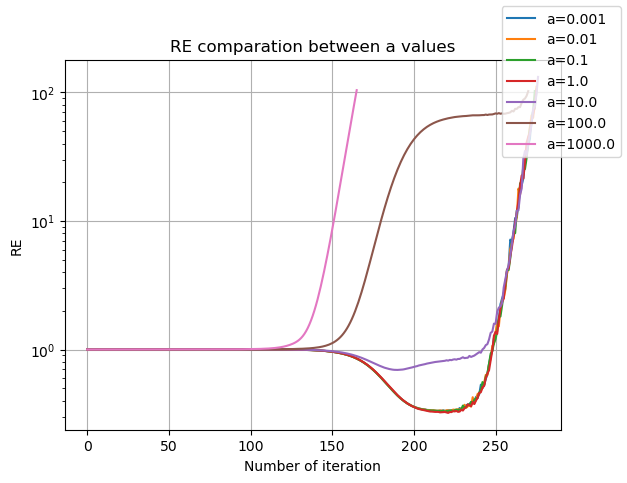

In [13]:
fig1, plt1 = plt.subplots()
a_min=0
re_min = float('inf')
for i,a_ in enumerate(alist):
    re = re_list[i]
    if min(re) < re_min:
        a_min = a_
        re_min = min(re)
    print(f'a:{a_:<7} minRE: {min(re):<20} argminRE: {re.index(min(re))}')
    plt1.plot(re, label=f'a={a_}')

fig1.legend()
plt1.grid(True)
plt1.set_title('RE comparation between a values')
plt1.set_yscale('log')
plt1.set_xlabel('Number of iteration')
plt1.set_ylabel('RE')
fig1.show()
print(f'Value of a for min RE is: {a_min}')

From the figure above, we can conclude that algorithm with $a = 10^{-3}, 10^{-2}, 10^{-1}, 1$ have almost the same performance and somehow toward to zero at iteration number 225.

In the other hands, the remaining value of $a$ have very bad performance & cannot recover anything from the image

## 5.2 - Experiment result

With the $a$ value had picked above, I re-run the NTRC algorithm with some more detail information of $convergence, RE, PSNR$ value.

I also visualize the output image for each 25 iterations to see the revolution of outputs.

In [14]:
T1, T_plt, convergence1, relative_error1, PSNR1 = NTRC_algorithm(y = noisy_tensor5d, Xn=uniform_sampled_tensors,
                                                                 T = reconstructed_tensor5d, Tk=circular_unfold_tensors,
                                                                 K=K, lambda_=calculate_lamda(a_min), alpha_k=alpha_k, isPlot=True)

5       conv:0.010009799152612686      RE:1.0006685256958008   PSNR:-67.12409973144531
10      conv:0.009998436085879803      RE:1.0011236667633057   PSNR:-62.98680877685547
15      conv:0.010006128810346127      RE:1.0017778873443604   PSNR:-58.850372314453125
20      conv:0.009986599907279015      RE:1.002820372581482    PSNR:-54.71562194824219
25      conv:6.978546057267044e-15     RE:1.0031658411026      PSNR:-53.77630615234375
30      conv:1.209605748897502e-10     RE:1.003143548965454    PSNR:-53.77670669555664
35      conv:3.168112994167416e-10     RE:1.0031431913375854   PSNR:-53.77699279785156
40      conv:8.192597711342842e-10     RE:1.0031383037567139   PSNR:-53.777435302734375
45      conv:3.008015170280487e-09     RE:1.0031373500823975   PSNR:-53.777137756347656
50      conv:7.875485152908368e-09     RE:1.0031368732452393   PSNR:-53.77680969238281
55      conv:2.0591311766793297e-08    RE:1.0031352043151855   PSNR:-53.77740478515625
60      conv:5.366651123495103e-08     R

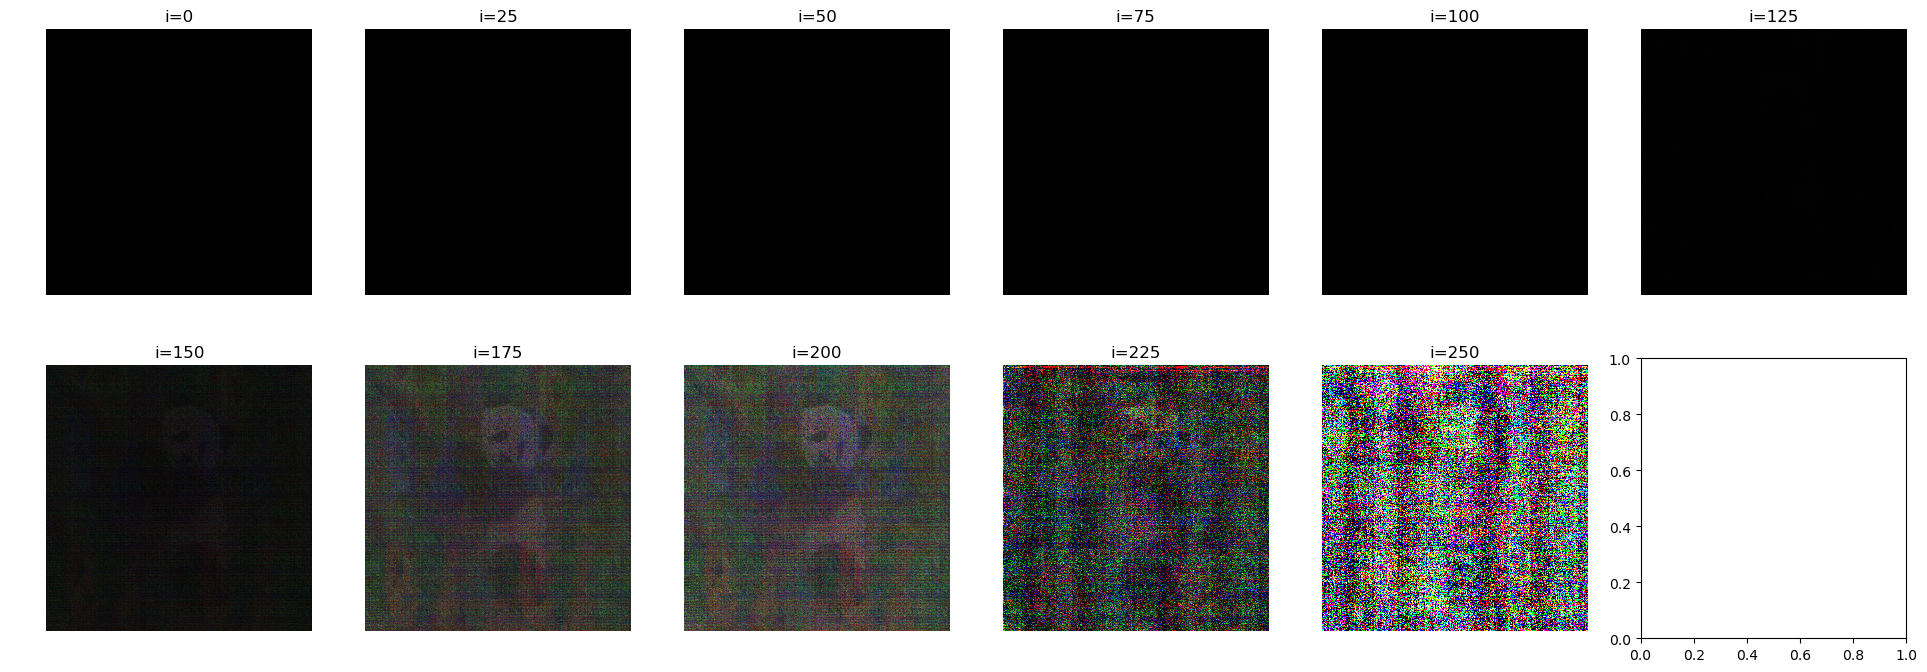

In [15]:
# Plot each tensor as an image
cols = 6
rows = (len(T_plt) + cols - 1) // cols
fig2, axes2 = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
for i, tensor in enumerate(T_plt):
    row = i // cols
    col = i % cols
    tensor=np.clip(tensor, 0, 1)
    axes2[row, col].imshow((tensor.view(3, 512, 512)).permute(1, 2, 0))
    axes2[row, col].axis('off')
    axes2[row, col].set_title(f'i={i*25}')
fig2.show()

Text(0.5, 1.0, 'Min RE Image, i=221')

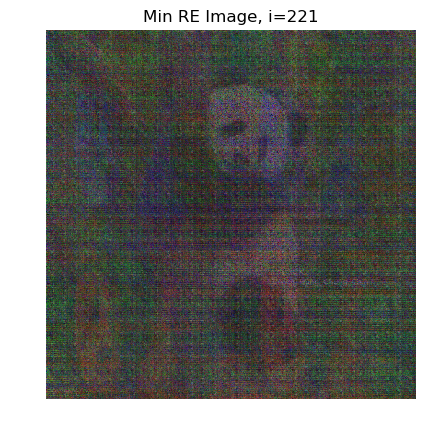

In [16]:
# Plot the min RE images
fig3, plt3 = plt.subplots()
plt3.imshow((np.clip(T1, 0, 1).view(3, 512, 512)).permute(1, 2, 0))
plt3.axis('off')
plt3.set_title(f'Min RE Image, i={relative_error1.index(min(relative_error1))}')

From 11 sample images and the minimum RE image, we can see:
* The NTRC is not able to recover anything until the iteration 175
* After reached the mumimum RE at the 221th iteration, the image become more noisy and hardly to see the image details when we continue to reconstruct the image
* Even at the minimum RE iteration, the output result still look bad & hard to see.

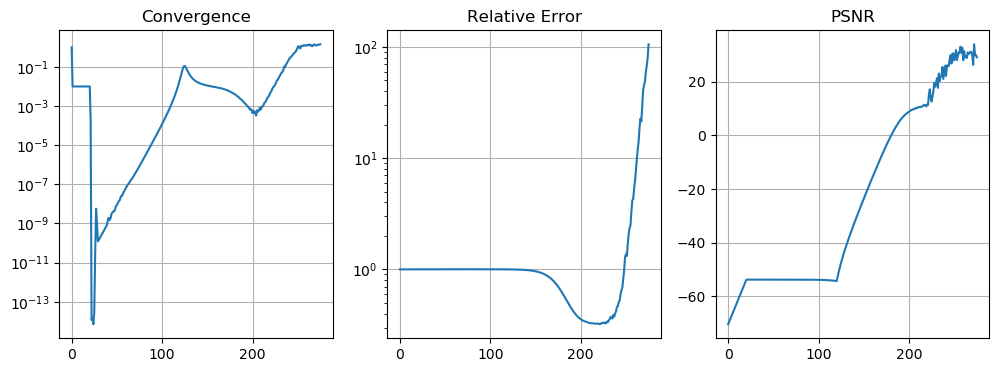

In [17]:
# Display the image
# Plot the images
fig4, axes4 = plt.subplots(1, 3, figsize=(12, 4))
# Plot the remaining plots
axes4[0].plot(convergence1)
axes4[0].set_title('Convergence')
axes4[0].set_yscale('log')
axes4[0].grid(True)

axes4[1].plot(relative_error1)
axes4[1].set_title('Relative Error')
axes4[1].set_yscale('log')
axes4[1].grid(True)

axes4[2].plot(PSNR1)
axes4[2].set_title('PSNR')
axes4[2].grid(True)

fig4.show()


* Look at the **Convergence** graph, we can say this implementation is not able to convergence toward zero. At the begining, it rapidly decrease but the outputs turn out just purely black images. 
* Look at the **Relative Error** graph, we can see the output  closely resembles the original around the 230th iteration. But when we continue to reconstruct tensors,it rapidly increase over a hundred before reaching a satisfactory output.

# 6 - Conclusion

From the above results, it's clear that my attempt to replicate the paper's algorithm didn't turn out as expected. While the orginal authors make the incomple, noisy images become smoother & almost fully recovered, my result is look even worse than the input image.

However, if we compare the results between the 1st iteration and the one with the minimum relative error (RE), we can see some progress. Although the picture isn't crystal clear, it can still make out some details, which is a vast improvement compared to the completely black initial image.

It's evident that there is still room for enhancement, possibly through parameter tuning, algorithmic adjustments, or exploring alternative methodologies to better address the complexities of the problem.

# Reference

[1] Qiu, Y., Zhou, G., Zhao, Q., & Xie, S. (2022). Noisy tensor completion via low-rank tensor ring. _IEEE Transactions on Neural Networks and Learning Systems._

[2] Yu, J., Li, C., Zhao, Q., & Zhao, G. (2019, May). Tensor-ring nuclear norm minimization and application for visual: Data completion. _In ICASSP 2019-2019 IEEE international conference on acoustics, speech and signal processing (ICASSP) (pp. 3142-3146). IEEE._